In this code example, we'll compute the control forces required for a 3D quadrotor to follow a trajectory.

In [1]:
%pylab inline
from pylab import *

import control
import mpl_toolkits.mplot3d
import scipy.integrate

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../lib")

import flashlight.curve_utils           as curve_utils
import flashlight.interpolate_utils     as interpolate_utils
import flashlight.ipython_display_utils as ipython_display_utils
import flashlight.quadrotor_3d          as quadrotor_3d
import flashlight.spline_utils          as spline_utils

Populating the interactive namespace from numpy and matplotlib
Initializing flashlight v0.0.1
flashlight.quadrotor_3d: Constructing sympy symbols...
flashlight.quadrotor_3d: Finished constructing sympy symbols (0.008 seconds).
flashlight.quadrotor_3d: Loading sympy modules...
flashlight.quadrotor_3d: Finished loading sympy modules (0.029 seconds).


/Users/mike/Code/GitHub/flashlight/code/lib/flashlight/transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


As in our previous examples, we begin by computing a 3D spline, and then re-timing the progress along the spline using an easing curve.

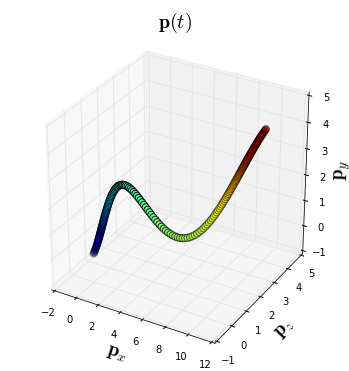

In [2]:
T_z = matrix([0,1,2,3]).T.A
T_y = matrix([0,1,2,3]).T.A
T_x = matrix([0,1,2,3]).T.A
T   = c_[T_z, T_y, T_x]
P_z = matrix([0,0,1,4]).T.A
P_y = matrix([0,3,1,4]).T.A
P_x = matrix([0,3,7,10]).T.A
P   = c_[P_z, P_y, P_x]

num_samples = 200

C, T, sd = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])
    
P_eval, T_eval, dT = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd, num_samples=num_samples)

T_s = matrix([0.0,1.2,1.8,3.0]).T.A
P_s = matrix([0.0,0.3,0.7,1.0]).T.A

C_s, T_s, sd_s = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P_s, T_s, degree=7, lamb=[0,0,0,1,0])
    
P_s_eval, T_s_eval, dT_s = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C_s, T_s, sd_s, num_samples=num_samples)

t = linspace(0.0,10.0,num_samples)
s_spline = P_s_eval

P_eval_spline, t_spline, P_eval_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s_spline)

figsize(6,6);
fig = plt.figure();
ax = fig.add_subplot(111, projection="3d");
ax.scatter(P_eval_spline[:,2], P_eval_spline[:,0], P_eval_spline[:,1], c=t, s=50);
title("$\\mathbf{p}(t)$\n", fontsize=20);
ax.set_zlabel("$\\mathbf{p}_y$", fontsize=20);
xlabel("$\\mathbf{p}_x$", fontsize=20); ylabel("$\\mathbf{p}_z$", fontsize=20);

As in our previous examples, we compute a state space trajectory, and then a control trajectory. Note that computing a state space trajectory for a 3D quadrotor requires that we specify the yaw angle of the quadrotor along the trajectory. In this example, we set the yaw angle to always be 0 for simplicity. In general, the yaw angle can be specified so that a quadrotor is oriented towards a particular target. For more details on the control problem being solved here, see [1].

#### References

[1] Niels Joubert, Mike Roberts, Anh Truong, Floraine Berthouzoz, Pat Hanrahan. An Interactive Tool for Designing Quadrotor Camera Shots. _ACM Transactions on Graphics 34(6) (SIGGRAPH Asia 2015)_.

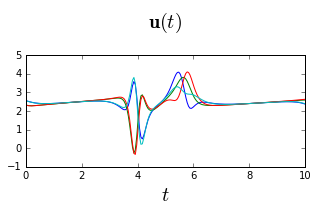

In [3]:
t_begin       = t[0]
t_end         = t[-1]
num_timesteps = num_samples

p   = P_eval_spline
psi = zeros_like(t)
dt  = (t_end-t_begin) / (num_timesteps-1)

q_qdot_qdotdot = quadrotor_3d.compute_state_space_trajectory_and_derivatives(p, psi, dt)
u              = quadrotor_3d.compute_control_trajectory(q_qdot_qdotdot)

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]); plot(t, u[:,2]); plot(t, u[:,3]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

We can simulate our control trajectory exactly as in our previous examples. As in our previous examples, we notice some simulation drift. Again, because we compute control forces numerically (i.e., inexactly), and we perform numerical (i.e., inexact) integration in our simulation, and we don't apply any feedback control, a small amount of drift is expected. In later examples, we'll apply time-varying LQR feedback control to elimate simulation drift and recover from unexpected disturbances.

In [4]:
x_nominal, q_nominal, qdot_nominal, qdotdot_nominal = \
    quadrotor_3d.pack_state_space_trajectory_and_derivatives(q_qdot_qdotdot)
    
x_0 = x_nominal[0]

def compute_x_dot(x_t, t):

    x_t     = matrix(x_t).T
    u_t     = u_interp_func(clip(t, t_begin, t_end))
    x_dot_t = quadrotor_3d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim = 200
t_sim             = linspace(t_begin, t_end, num_timesteps_sim)
u_interp_func     = interpolate_utils.interp1d_vector_wrt_scalar(t, u, kind="cubic")
x_sim             = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

quadrotor_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal)
# quadrotor_3d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, savefig=True, out_dir="data/08", out_file="00.mp4")
ipython_display_utils.get_inline_video("data/08/00.mp4")